# 숫자 분류 모델 제작
- MNIST 데이터셋으로부터 학습함
- 참고자료: https://keras.io/examples/vision/mnist_convnet

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

## 데이터 가져오기
- keras에서 제공하는 MNIST 데이터셋 사용

In [12]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

## 데이터 살펴보기

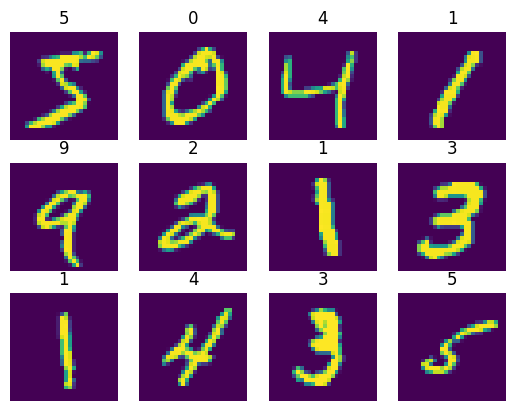

In [13]:
from numpy.random import choice

NUM_SAMPLES = 12
samples = choice(len(x_train), NUM_SAMPLES)
for i in range(NUM_SAMPLES):
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.imshow(x_train[i])
    plt.title(y_train[i])
plt.show()

## 데이터 전처리
- [0, 255] 범위의 정수를 [0, 1] 범위의 실수로 변환
- Keras API에 사용하기 위해 행렬을 28x28에서 28x28x1로 변환
- y값에 one hot encoding을 적용함

In [14]:
x_train = x_train.reshape(-1, 28, 28, 1) / 255
x_test = x_test.reshape(-1, 28, 28, 1) / 255
x_train.shape, x_train.dtype

((60000, 28, 28, 1), dtype('float64'))

In [15]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_train.dtype

((60000, 10), dtype('float32'))

## 데이터 증강

In [16]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='constant',
    cval=0,
)

## 모델 구성

In [17]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

kernel_size = (3, 3)

model = Sequential([
    Conv2D(64, kernel_size, activation='relu', input_shape=(28, 28, 1)),
    Conv2D(64, kernel_size, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(128, kernel_size, activation='relu'),
    Conv2D(128, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(256, kernel_size, activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 12, 12, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)        

## 모델 학습
- 검증 데이터 기준 98% 정확도

In [18]:
history = model.fit(
    generator.flow(x_train, y_train, batch_size=512),
    # x_train, y_train,
    epochs=15,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/15


2023-09-07 17:15:52.511123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.9374

2023-09-07 17:16:09.462547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


118/118 [==============================] - 20s 150ms/step - loss: 0.2044 - accuracy: 0.9374 - val_loss: 1.9581 - val_accuracy: 0.4536
Epoch 2/15
118/118 [==============================] - 16s 135ms/step - loss: 0.0680 - accuracy: 0.9794 - val_loss: 1.3414 - val_accuracy: 0.6317
Epoch 3/15
118/118 [==============================] - 17s 140ms/step - loss: 0.0539 - accuracy: 0.9835 - val_loss: 0.7094 - val_accuracy: 0.7317
Epoch 4/15
118/118 [==============================] - 16s 136ms/step - loss: 0.0499 - accuracy: 0.9845 - val_loss: 0.0919 - val_accuracy: 0.9710
Epoch 5/15
118/118 [==============================] - 16s 131ms/step - loss: 0.0439 - accuracy: 0.9869 - val_loss: 0.0489 - val_accuracy: 0.9851
Epoch 6/15
118/118 [==============================] - 15s 131ms/step - loss: 0.0410 - accuracy: 0.9872 - val_loss: 0.0511 - val_accuracy: 0.9855
Epoch 7/15
118/118 [==============================] - 15s 131ms/step - loss: 0.0374 - accuracy: 0.9887 - val_loss: 0.0664 - val_accuracy: 0.9

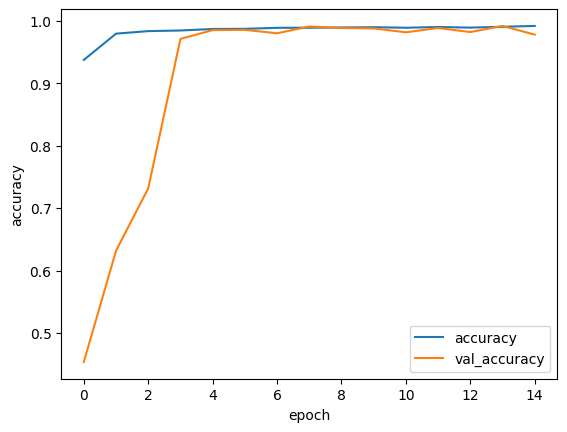

In [19]:
# draw accuracy and val_accuracy graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# 모델 저장

In [20]:
model.save(f"../model.keras")